In [1]:
# ! pip install yfinance
import Ab as ab
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get data from yahoo finance
sd = dt.datetime(1998,12,4)
ed = dt.datetime(2023,3,3)
# 1x leveraged nasdaq 100 etf
qqq = ab.StockData('QQQ')
qqq.get_data_from_yfinance('QQQ', sd, ed)
# 2x leveraged nasdaq 100 etf
qld = ab.StockData('QLD')
qld.get_data_from_yfinance('QLD', sd, ed)
# 3x leveraged nasdaq 100 etf
tqqq = ab.StockData('TQQQ')
tqqq.get_data_from_yfinance('TQQQ', sd, ed)
#nasdaq 100 index
ndx = ab.StockData('NDX')
ndx.get_data_from_yfinance('NDX', sd, ed)
#S&P 500 etf
spy = ab.StockData('SPY')
spy.get_data_from_yfinance('SPY', sd, ed)
#nasdaq stocks above 200 day moving average percentage
naa200r = ab.StockData('NAA200R')
naa200r.get_data_from_csv('data/NAA200R.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
def ffty_and_spy_strategy_signal(sd, ed, ffty_sell_threshold = 0.95, ffty_buy_threshold = 1.02, spy_consecutive_buy_threshold = 1, spy_consecutive_days = 10, spy_max_off_new_high_pct = -0.2):
    
    ## ffty signals
    ffty = ab.StockData('FFTY')
    ffty.get_data_from_yfinance('FFTY',sd, ed)
    ffty.get_indicators()
    ffty_signals_df = ffty.data.copy()
    ffty_signals_df['Signal'] = np.where(ffty_signals_df.price_to_MA200 < ffty_sell_threshold, -1, np.where(ffty_signals_df.price_to_MA200 > ffty_buy_threshold, 1, 0))
    ffty_signals_df = ffty_signals_df[['Signal']]

    ## spy signals
    spy = ab.StockData('SPY')
    spy.get_data_from_yfinance('SPY', sd, ed)
    spy.get_indicators()
    spy.data['new_high'] = spy.data['Close'].cummax()
    spy.data['off_new_high'] = spy.data['Close'] / spy.data['new_high'] - 1
    spy.data['max_off_new_high'] = spy.data['off_new_high'].rolling(252).min()
    spy.data['Close_prev'] = spy.data['Close'].shift(spy_consecutive_days)
    spy.data['price_to_MA200_prev'] = spy.data['price_to_MA200'].shift(spy_consecutive_days)

    spy_signals_df = spy.data.copy()
    # buy rule: two consecutive weeks of above 200 AND previously SPY DOWN 20%
    buy_rule = (spy_signals_df['max_off_new_high']< spy_max_off_new_high_pct ) & (spy_signals_df['price_to_MA200'] > spy_consecutive_buy_threshold) & (spy_signals_df['price_to_MA200_prev'] >  spy_consecutive_buy_threshold)
    spy_signals_df['Signal'] = np.where(buy_rule, 1, 0)
    spy_signals_df = spy_signals_df[['Signal']]

    signals_df = ffty_signals_df.rename(columns={'Signal':'FFTY_Signal'}).join(spy_signals_df.rename(columns={'Signal':'SPY_Signal'}), how='outer')
    signals_df['Signal']= np.where((signals_df['SPY_Signal']==1)|(signals_df['FFTY_Signal']==1), 1, np.where(signals_df['FFTY_Signal']==-1, -1, 0))

    return signals_df


ticker = qqq

In [22]:
#buy and hold strategy vs various  strategies
def backtestAll(ticker:ab.StockData,test_start:dt.datetime,test_end:dt.datetime, weekly_trading = False, verbose = True):
    perf_summary = pd.DataFrame()
    buy_and_hold = ab.BuyAndHold() 
    buy_and_hold.run_strategy(ticker, test_start,test_end)
    bt = ab.BackTest(test_start, test_end)
    bt.run_backtest(buy_and_hold, ticker, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    # macross_strategy = ab.MACross('Ma Cross',50, 200)
    # macross_strategy.run_strategy(ticker, test_start ,test_end)
    # ma_cross_bt = ab.BackTest(test_start, test_end)
    # ma_cross_bt.run_backtest(macross_strategy, ticker)#, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    threshold_strategy = ab.Threshold(signal_data = naa200r, name='NAA200R', indicator = 'SignalPrice', buy_threshold = 15, sell_threshold = 30)
    threshold_strategy.run_strategy(ticker, test_start , test_end)
    naa200r_threshold_bt = ab.BackTest(test_start , test_end)
    naa200r_threshold_bt.run_backtest(threshold_strategy, ticker, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    # ma_threshold = ab.MAThreshold('SMA200', ma_window = 200,buy_threshold = 1.05, sell_threshold = 0.95)
    # ma_threshold.run_strategy(ticker, test_start,test_end)
    # ma_threshold_bt = ab.BackTest(test_start, test_end)
    # ma_threshold_bt.run_backtest(ma_threshold, ticker, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    # ma_threshold2 = ab.MAThreshold('SMA200', ma_window = 200,buy_threshold = 1.03, sell_threshold = 0.95)
    # ma_threshold2.run_strategy(ticker, test_start,test_end)
    # ma_threshold2_bt = ab.BackTest(test_start, test_end)
    # ma_threshold2_bt.run_backtest(ma_threshold2, ticker, weekly_buy = weekly_trading, weekly_sell = weekly_trading)
    
    WeeklyMAThreshold = ab.WeeklyMAThreshold('2W SMA200', ma_window =40,buy_threshold=1,sell_threshold=1)
    WeeklyMAThreshold.run_strategy(ticker, test_start , test_end)
    WeeklyMAThreshold_bt = ab.BackTest(test_start , test_end)
    WeeklyMAThreshold_bt.run_backtest(WeeklyMAThreshold, ticker, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    signals_df = ffty_and_spy_strategy_signal(sd, ed, ffty_sell_threshold = 0.95, ffty_buy_threshold = 1.02, 
                                            spy_consecutive_buy_threshold = 1, spy_consecutive_days = 5,
                                            spy_max_off_new_high_pct = -0.2)
    fftystrategy = ab.CustomizedStrategy(signals_df = signals_df)
    fftystrategy.run_strategy(ticker, test_start,test_end)
    fftystrategy_bt = ab.BackTest(test_start, test_end)
    fftystrategy_bt.run_backtest(fftystrategy, ticker, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    signals_df = ffty_and_spy_strategy_signal(sd, ed, ffty_sell_threshold = 0.95, ffty_buy_threshold = 1.02, 
                                            spy_consecutive_buy_threshold = 1, spy_consecutive_days = 20,
                                            spy_max_off_new_high_pct = -0.2)
    fftystrategy_month = ab.CustomizedStrategy(signals_df = signals_df)
    fftystrategy_month.run_strategy(ticker, test_start,test_end)
    fftystrategy_bt_month = ab.BackTest(test_start, test_end)
    fftystrategy_bt_month.run_backtest(fftystrategy_month, ticker, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    print('Backtest for', ticker.ticker)
    bt.performance_summary(v = verbose)
    # ma_cross_bt.performance_summary(v = verbose)
    naa200r_threshold_bt.performance_summary(v = verbose)
    # ma_threshold_bt.performance_summary(v = verbose)
    # ma_threshold2_bt.performance_summary(v = verbose)
    WeeklyMAThreshold_bt.performance_summary(v = verbose)
    fftystrategy_bt.performance_summary(v = verbose)
    fftystrategy_bt_month.performance_summary(v = verbose)

    fig = plt.figure(figsize=(16,4))
    plt.plot(bt.balance['Date'], bt.balance['Total'], label = bt.name)
    # plt.plot(ma_cross_bt.balance['Date'], ma_cross_bt.balance['Total'], label = ma_cross_bt.name)
    plt.plot(naa200r_threshold_bt.balance['Date'], naa200r_threshold_bt.balance['Total'], label = naa200r_threshold_bt.name)
    # plt.plot(ma_threshold_bt.balance['Date'], ma_threshold_bt.balance['Total'], label = ma_threshold_bt.name)
    # plt.plot(ma_threshold2_bt.balance['Date'], ma_threshold2_bt.balance['Total'], label = ma_threshold2_bt.name)
    plt.plot(WeeklyMAThreshold_bt.balance['Date'], WeeklyMAThreshold_bt.balance['Total'], label = WeeklyMAThreshold_bt.name)
    plt.plot(fftystrategy_bt.balance['Date'], fftystrategy_bt.balance['Total'], label = 'FFTY_SPY_Strategy 2w above')
    plt.plot(fftystrategy_bt_month.balance['Date'], fftystrategy_bt_month.balance['Total'], label = 'FFTY_SPY_Strategy 2m above')

    plt.legend()
    plt.title('Backtesting for {}'.format(ticker.ticker))
    plt.show()


    for strategy in [bt,
    # ma_cross_bt,
    naa200r_threshold_bt, 
    # ma_threshold_bt, 
    # ma_threshold2_bt, 
    WeeklyMAThreshold_bt, 
    fftystrategy_bt,
    fftystrategy_bt_month]:
        perf_summary = pd.concat([perf_summary, strategy.summary_result])
        
    return perf_summary

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Backtest for QQQ


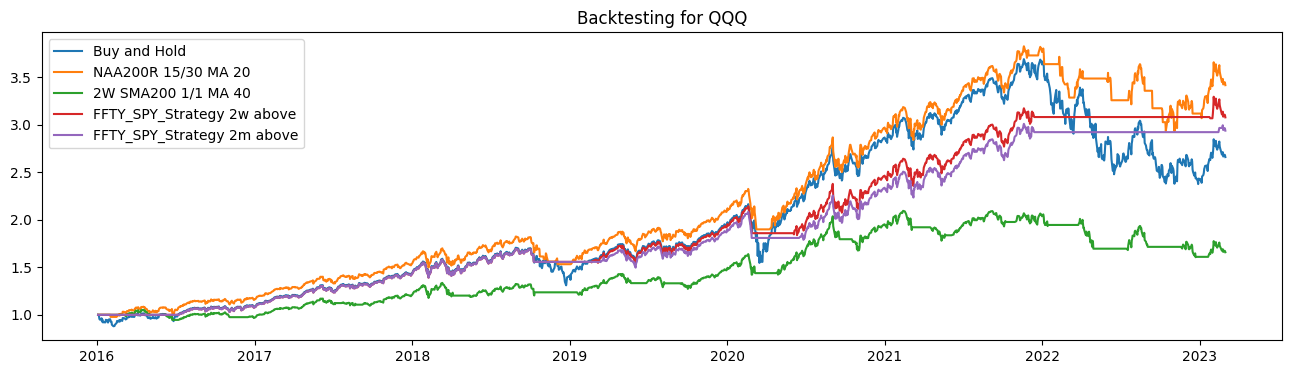

,name,num_trades,cumulative_return,annual_return,max_drawdown,sharp_ratio,avg_daily_return,std_daily_return,num_trading_days,Betting Average,Gain Average,Loss Average,Risk Reward Ratio,Gain STD,Loss STD
0,Buy and Hold,2,1.659361,0.051948,-0.355207,0.044377,0.000651,0.014677,2616,1.000000,1.659361,NaN,NaN,NaN,NaN
0,NAA200R 15/30 MA 20,18,2.415776,0.092209,-0.233286,0.065366,0.000748,0.011442,2616,0.411765,0.295664,-0.036324,8.139731,0.367487,0.018664
0,2W SMA200 1/1 MA 40,20,0.658376,-0.040936,-0.222358,0.033810,0.000328,0.009706,2616,0.578947,0.081004,-0.039839,2.033289,0.067697,0.042532
0,Customized,6,2.077158,0.075838,-0.142036,0.074396,0.000664,0.008929,2616,0.800000,0.352815,-0.004257,82.886961,0.306518,NaN
0,Customized,6,1.937161,0.068357,-0.141645,0.073534,0.000636,0.008648,2616,0.800000,0.337255,-0.009625,35.040135,0.294458,NaN


In [23]:
test_start,test_end = dt.datetime(2016,1,1), dt.datetime(2023,3,1)

perf_summary = backtestAll(qqq, test_start, test_end, weekly_trading = False, verbose = False)
display(perf_summary)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Backtest for QQQ


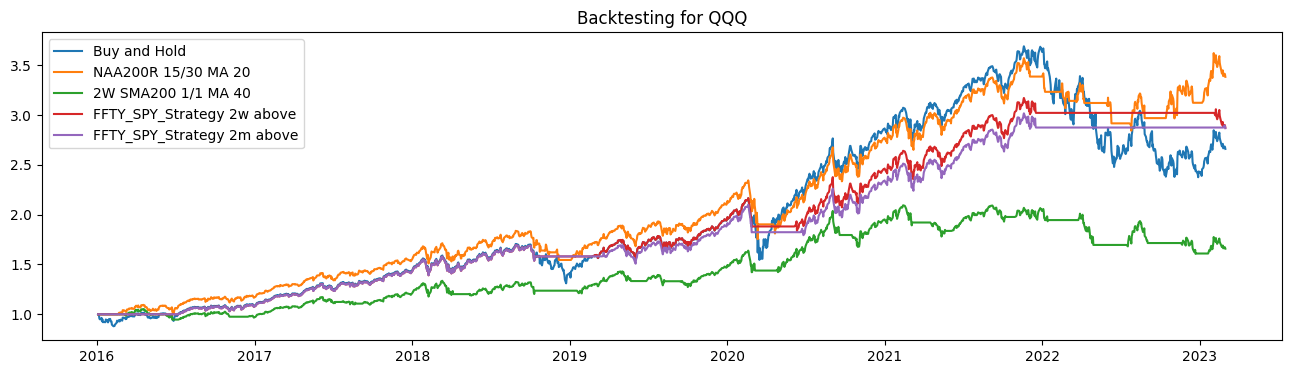

,name,num_trades,cumulative_return,annual_return,max_drawdown,sharp_ratio,avg_daily_return,std_daily_return,num_trading_days,Betting Average,Gain Average,Loss Average,Risk Reward Ratio,Gain STD,Loss STD
0,Buy and Hold,2,1.659361,0.051948,-0.355207,0.044377,0.000651,0.014677,2616,1.000000,1.659361,NaN,NaN,NaN,NaN
0,NAA200R 15/30 MA 20,13,2.382558,0.090698,-0.251751,0.063425,0.000746,0.011766,2616,0.500000,0.300633,-0.033969,8.850100,0.328118,0.022808
0,2W SMA200 1/1 MA 40,20,0.658376,-0.040936,-0.222358,0.033810,0.000328,0.009706,2616,0.578947,0.081004,-0.039839,2.033289,0.067697,0.042532
0,Customized,5,1.873235,0.064778,-0.152115,0.070232,0.000626,0.008915,2616,0.750000,0.458878,-0.048925,9.379144,0.232898,NaN
0,Customized,5,1.867596,0.064457,-0.145866,0.071599,0.000623,0.008703,2616,0.750000,0.436759,-0.002227,196.106750,0.244964,NaN


In [25]:
test_start,test_end = dt.datetime(2016,1,1), dt.datetime(2023,3,1)

perf_summary = backtestAll(qqq, test_start, test_end, weekly_trading = True, verbose = False)
display(perf_summary)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Backtest for QLD


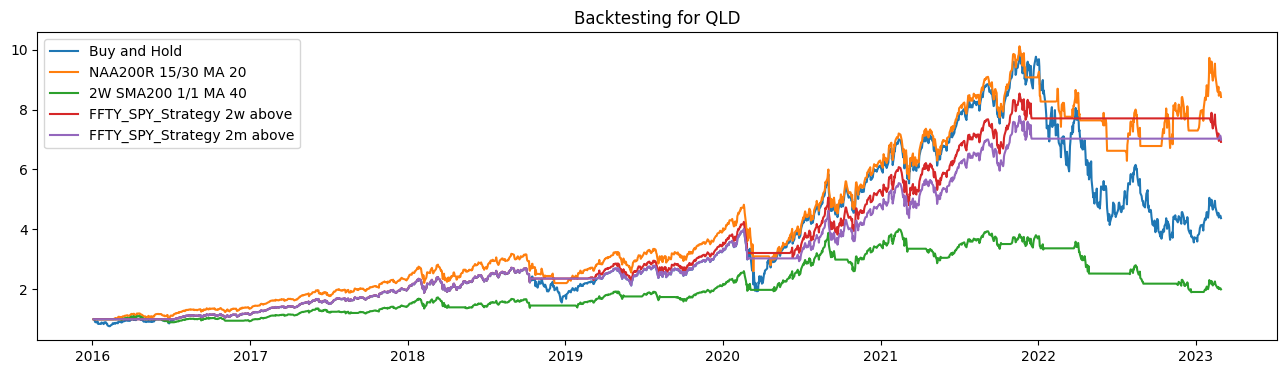

,name,num_trades,cumulative_return,annual_return,max_drawdown,sharp_ratio,avg_daily_return,std_daily_return,num_trading_days,Betting Average,Gain Average,Loss Average,Risk Reward Ratio,Gain STD,Loss STD
0,Buy and Hold,2,3.374484,0.129330,-0.631892,0.042753,0.001255,0.029355,2616,1.000000,3.374484,NaN,NaN,NaN,NaN
0,NAA200R 15/30 MA 20,13,7.419161,0.221899,-0.460173,0.062104,0.001463,0.023553,2616,0.500000,0.683124,-0.070565,9.680746,0.824393,0.044470
0,2W SMA200 1/1 MA 40,20,0.996918,-0.000309,-0.500676,0.029799,0.000566,0.019000,2616,0.526316,0.174574,-0.087560,1.993755,0.143770,0.077935
0,Customized,5,5.919675,0.194620,-0.281378,0.069438,0.001234,0.017770,2616,0.750000,1.039740,-0.101925,10.201057,0.587419,NaN
0,Customized,5,5.994387,0.196119,-0.268339,0.071061,0.001232,0.017339,2616,0.750000,0.987458,-0.004847,203.715724,0.608415,NaN


In [27]:
perf_summary = backtestAll(qld, test_start, test_end, weekly_trading = True, verbose = False)
display(perf_summary)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Backtest for TQQQ


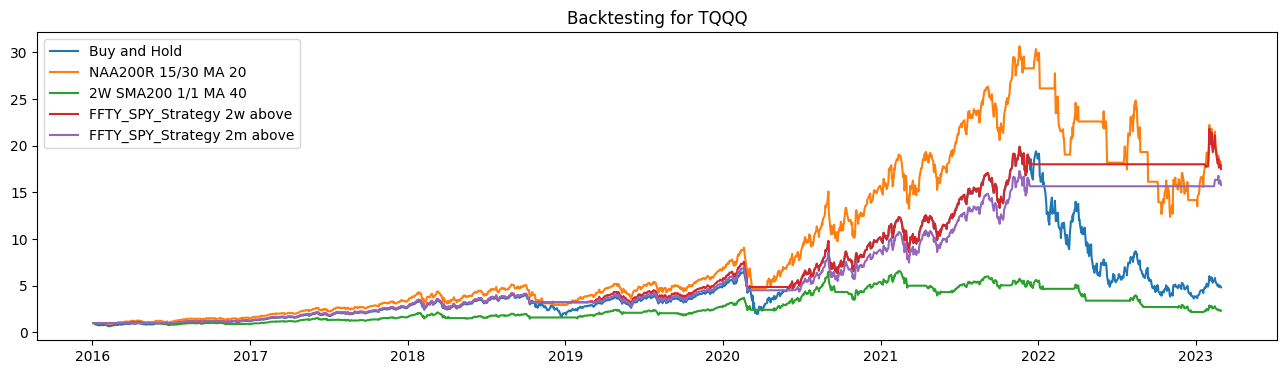

,name,num_trades,cumulative_return,annual_return,max_drawdown,sharp_ratio,avg_daily_return,std_daily_return,num_trading_days,Betting Average,Gain Average,Loss Average,Risk Reward Ratio,Gain STD,Loss STD
0,Buy and Hold,2,3.831329,0.143760,-0.811138,0.042260,0.001832,0.043355,2616,1.000000,3.831329,NaN,NaN,NaN,NaN
0,NAA200R 15/30 MA 20,18,16.822506,0.326139,-0.596052,0.064360,0.002183,0.033913,2616,0.411765,1.261003,-0.108640,11.607131,1.899832,0.055841
0,2W SMA200 1/1 MA 40,20,1.320976,0.028228,-0.611759,0.030912,0.000859,0.027775,2616,0.526316,0.248793,-0.125018,1.990060,0.232315,0.087232
0,Customized,6,16.490497,0.323498,-0.384623,0.073437,0.001946,0.026502,2616,0.600000,1.811872,-0.014425,125.608829,1.153990,0.001526
0,Customized,6,14.791718,0.309188,-0.378281,0.072746,0.001867,0.025667,2616,0.800000,1.284555,-0.034004,37.776033,1.239952,NaN


In [30]:
perf_summary = backtestAll(tqqq, test_start, test_end, weekly_trading = False, verbose = False)
display(perf_summary)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Backtest for SPY


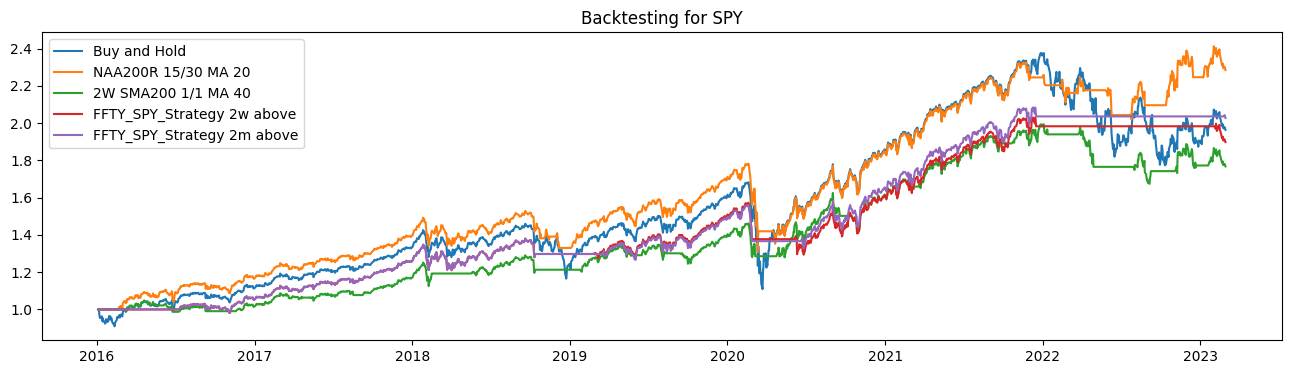

,name,num_trades,cumulative_return,annual_return,max_drawdown,sharp_ratio,avg_daily_return,std_daily_return,num_trading_days,Betting Average,Gain Average,Loss Average,Risk Reward Ratio,Gain STD,Loss STD
0,Buy and Hold,2,0.963685,-0.003692,-0.341047,0.037274,0.000447,0.011993,2616,1.000000,0.963685,NaN,NaN,NaN,NaN
0,NAA200R 15/30 MA 20,13,1.285162,0.025406,-0.266684,0.053600,0.000503,0.009390,2616,0.666667,0.144900,-0.035658,4.063638,0.216181,0.020790
0,2W SMA200 1/1 MA 40,19,0.767685,-0.026091,-0.160256,0.046284,0.000344,0.007434,2616,0.722222,0.058757,-0.030277,1.940685,0.055551,0.035148
0,Customized,5,0.898641,-0.010630,-0.177265,0.056335,0.000379,0.006724,2616,0.750000,0.266356,-0.042706,6.236895,0.191299,NaN
0,Customized,5,1.027847,0.002750,-0.148742,0.063947,0.000414,0.006468,2616,0.750000,0.280268,-0.004137,67.738872,0.218941,NaN


In [31]:
perf_summary = backtestAll(spy, test_start, test_end, weekly_trading = True, verbose = False)
display(perf_summary)

In [45]:
test_start,test_end = dt.datetime(2016,1,1), dt.datetime(2023,3,1)
sd, ed = dt.datetime(1998,12,4), dt.datetime(2023,3,1)

In [41]:
def ffty_spy_performance(ticker, sd, ed, ffty_sell_threshold = 0.95, ffty_buy_threshold = 1.02, 
                                         spy_consecutive_buy_threshold = 1, spy_consecutive_days = 5,
                                         spy_max_off_new_high_pct = -0.2, signal_ma_window = 200,
                                           visualization=True):
    

    ticker_data = ticker.data.sort_index().loc[sd:ed].copy()
    ticker_name = ticker.ticker

    ffty = ab.StockData('FFTY')
    ffty.get_data_from_yfinance('FFTY', sd, ed)
    ffty.get_indicators()
    ffty_data = ffty.data.sort_index().loc[sd:ed].copy()

    spy = ab.StockData('SPY')
    spy.get_data_from_yfinance('SPY', sd, ed)
    spy.get_indicators()
    spy_data = spy.data.sort_index().loc[sd:ed].copy()

    signals_df = ffty_and_spy_strategy_signal(dt.datetime(1998,12,4), dt.date.today(), ffty_sell_threshold, ffty_buy_threshold, 
                                         spy_consecutive_buy_threshold, spy_consecutive_days,  spy_max_off_new_high_pct)
    
    mystrategy = ab.CustomizedStrategy(signals_df = signals_df)
    mystrategy.run_strategy(ticker, test_start,test_end)
    mystrategy_bt = ab.BackTest(test_start, test_end)
    mystrategy_bt.run_backtest(mystrategy, ticker)
    print(mystrategy_bt.performance_summary('FFTY+SPY'))

    if visualization == True:
        
        # get trade list

        df_balance = mystrategy_bt.balance
        df_balance['Trade'] = np.where(df_balance['Stock'].diff()>0, 1, np.where(df_balance['Stock'].diff()<0, -1, 0))

        # plots
        fig = plt.figure(figsize=(16,4))
        ffty_data['Close'].plot(label='FFTY')
        ffty_data['MA'+str(signal_ma_window)].plot(label='FFTY MA{}'.format(signal_ma_window))

        trades = df_balance.loc[df_balance['Trade']!=0]
        for idx, row in trades.iterrows():
            if row['Trade']<0:
                plt.axvline(x=row.Date, color = 'red', linestyle='dashed') 
            if row['Trade']>0:
                plt.axvline(x=row.Date, color = 'green', linestyle='dashed') 

        # plt.ylim([0, 50])
        plt.title('Trading Signals And FFTY')
        plt.legend()
        plt.show()

        fig = plt.figure(figsize=(16,4))
        spy_data['Close'].plot(label='SPY')
        spy_data['MA'+str(signal_ma_window)].plot(label='SPY MA{}'.format(signal_ma_window))

        trades = df_balance.loc[df_balance['Trade']!=0]
        for idx, row in trades.iterrows():
            if row['Trade']<0:
                plt.axvline(x=row.Date, color = 'red', linestyle='dashed') 
            if row['Trade']>0:
                plt.axvline(x=row.Date, color = 'green', linestyle='dashed') 

        # plt.ylim([0, 50])
        plt.title('Trading Signals And SPY')
        plt.legend()
        plt.show()

        fig = plt.figure(figsize=(16,4))
        ticker_data['Close'].plot()

        trades = df_balance.loc[df_balance['Trade']!=0]
        for idx, row in trades.iterrows():
            if row['Trade']<0:
                plt.axvline(x=row.Date, color = 'red', linestyle='dashed') 
            if row['Trade']>0:
                plt.axvline(x=row.Date, color = 'green', linestyle='dashed') 
        plt.title('Trading Signals And {}'.format(ticker_name))
        plt.show()

        fig = plt.figure(figsize=(16,4))
        df_balance.plot(x = 'Date', y = 'Total', title = 'Portfolio Performance of {}'.format(ticker_name), figsize=(16,4))
    


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Customized: 
cumulative return      : 193.72%
compound anual return  : 6.8357% 
max_drawdown           : -14.16%
sharp_ratio            : 7.35%
average of daily return: 0.0636%
std of daily return    : 0.8648%
number of trades       : 6,
trading days           : 2616,
Betting Average        : 80.00%
Gain Average           : 33.73%
Loss Average           : -0.96%
Risk Reward Ratio      : 35.04
Gain STD               : 29.45%
Loss STD               : nan%
        
None


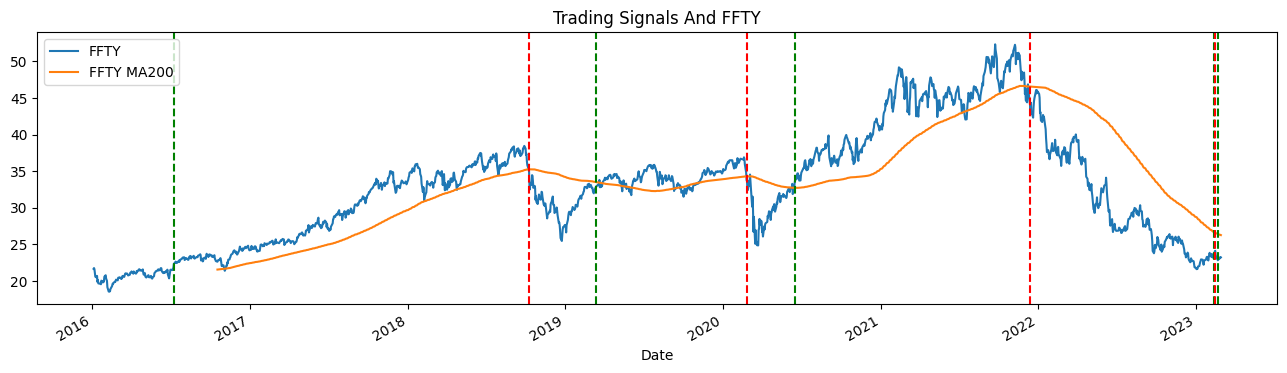

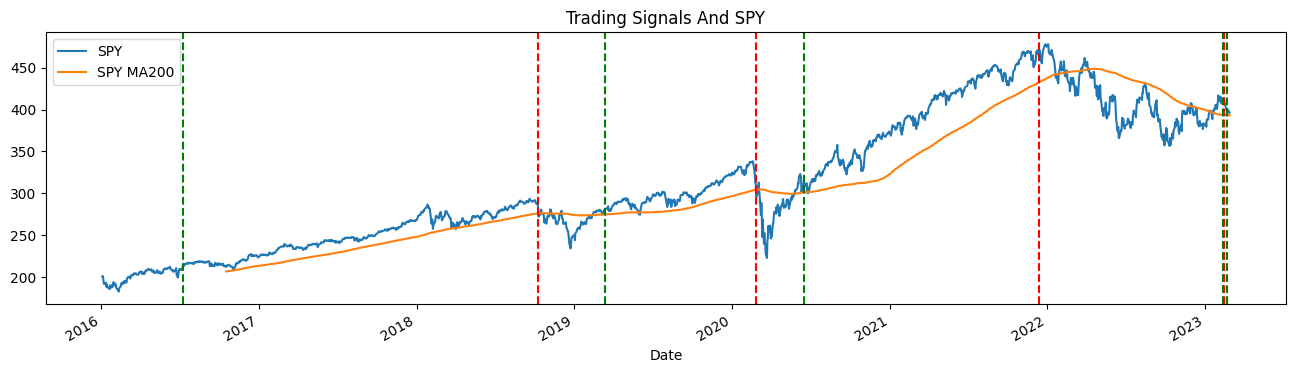

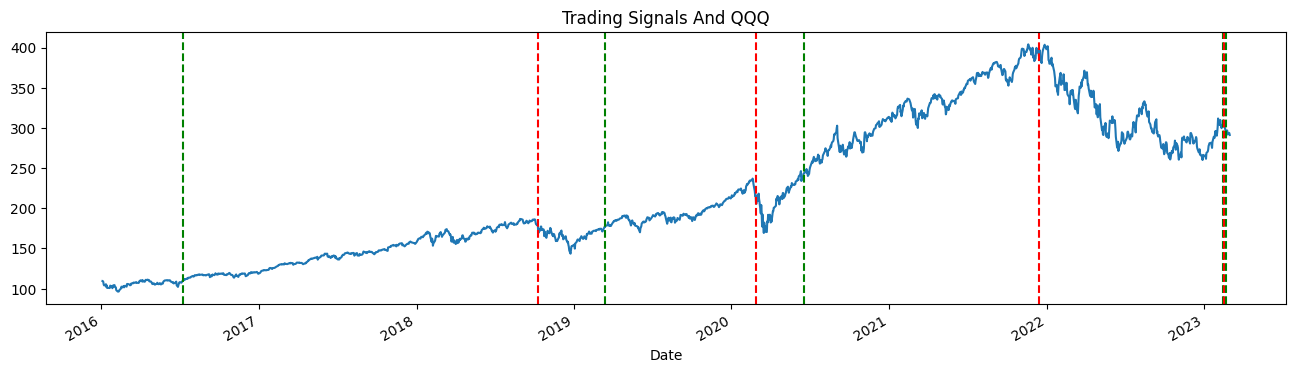

<Figure size 1600x400 with 0 Axes>

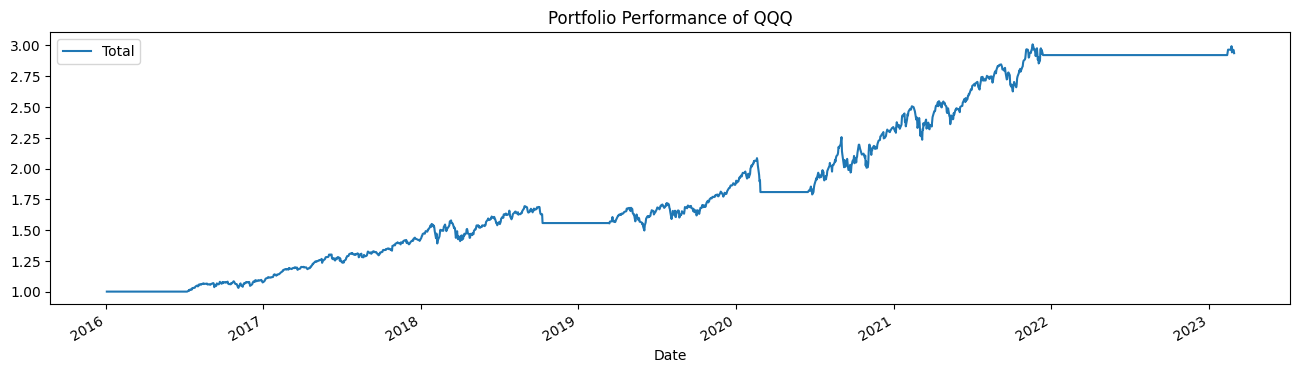

In [42]:
ffty_spy_performance(qqq, test_start, test_end, ffty_sell_threshold = 0.95, ffty_buy_threshold = 1.02, 
                                            spy_consecutive_buy_threshold = 1, spy_consecutive_days = 20,
                                            spy_max_off_new_high_pct = -0.2,
                                           visualization=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Customized: 
cumulative return      : 207.72%
compound anual return  : 7.5838% 
max_drawdown           : -14.20%
sharp_ratio            : 7.44%
average of daily return: 0.0664%
std of daily return    : 0.8929%
number of trades       : 6,
trading days           : 2616,
Betting Average        : 80.00%
Gain Average           : 35.28%
Loss Average           : -0.43%
Risk Reward Ratio      : 82.89
Gain STD               : 30.65%
Loss STD               : nan%
        
None


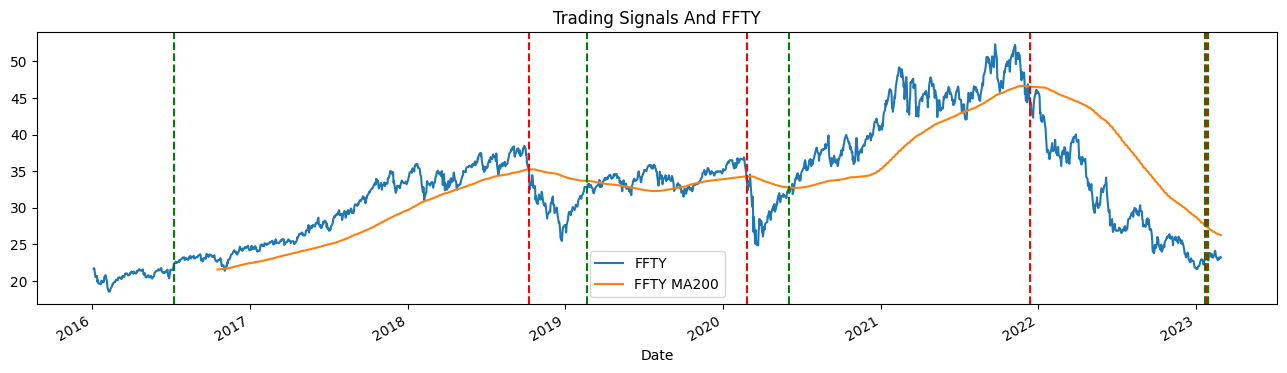

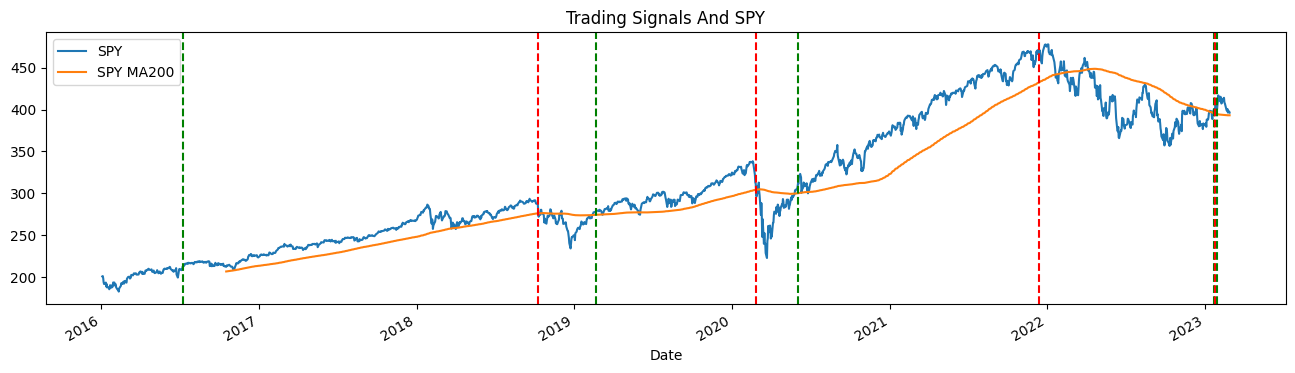

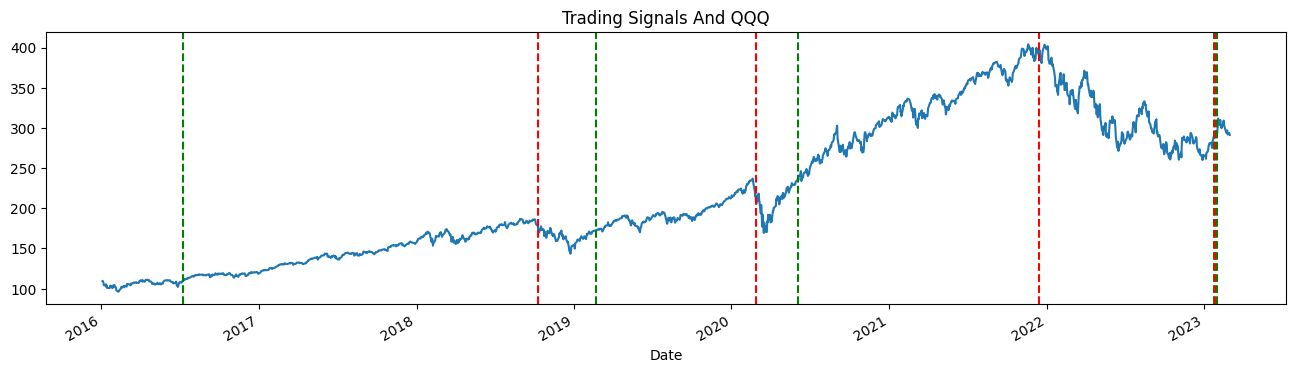

<Figure size 1600x400 with 0 Axes>

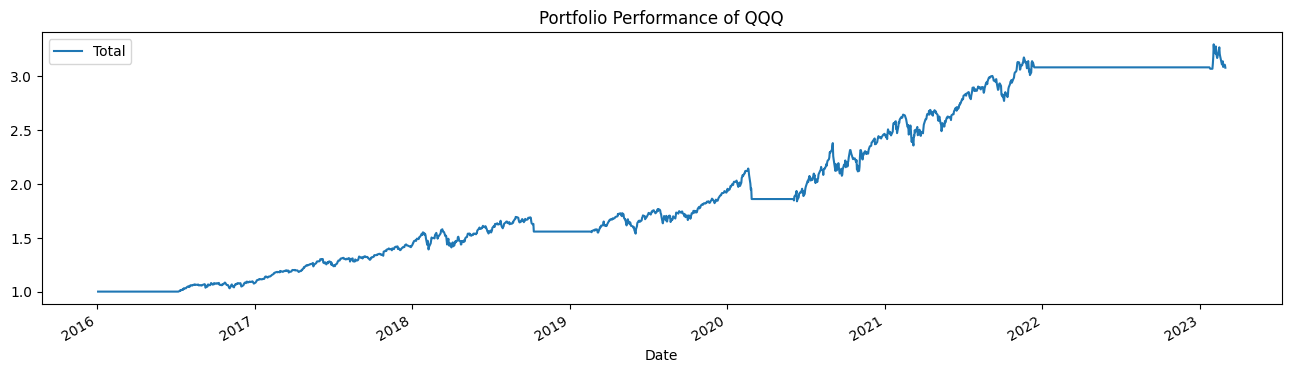

In [43]:
ffty_spy_performance(qqq, test_start, test_end, ffty_sell_threshold = 0.95, ffty_buy_threshold = 1.02, 
                                            spy_consecutive_buy_threshold = 1, spy_consecutive_days = 5,
                                            spy_max_off_new_high_pct = -0.2,
                                           visualization=True)

In [44]:
def naa200r_performance(ticker, sd, ed, signal_ma_window = 20, buy_threshold = 15 , sell_threshold = 30,  weekly_trading = True, visualization=True):
    
    signal_data = naa200r.data.sort_index().loc[sd:ed].copy()
    ticker_data = ticker.data.sort_index().loc[sd:ed].copy()
    ticker_name = ticker.ticker
    
    threshold_strategy = ab.Threshold(signal_data = naa200r, indicator = 'SignalPrice', 
                                    buy_threshold = buy_threshold , sell_threshold = sell_threshold , 
                                    signal_ma_window=signal_ma_window )

    # run strategy
    threshold_strategy.run_strategy(ticker, sd , ed)
    naa200r_threshold_bt = ab.BackTest(sd , ed)
    naa200r_threshold_bt.run_backtest(threshold_strategy, ticker, weekly_buy = weekly_trading, weekly_sell=weekly_trading)
    print(naa200r_threshold_bt.performance_summary('{}: NAA200R (buy {}, sell {}, MA{})'.format(ticker_name, 
                                                                                         buy_threshold, sell_threshold, signal_ma_window)))


    if visualization == True:
        
        # get trade list
        df_balance = naa200r_threshold_bt.balance
        df_balance['Trade'] = np.where(df_balance['Stock'].diff()>0, 1, np.where(df_balance['Stock'].diff()<0, -1, 0))

        # plots
        fig = plt.figure(figsize=(16,4))
        signal_data['Close'].plot(label='NAA200R')
        signal_data['Close'].rolling(signal_ma_window).mean().plot(label='NAA200R MA{}'.format(signal_ma_window))


        plt.axhline(y = 15, color = 'black', linestyle='dashed') 
        plt.axhline(y = 30, color = 'black', linestyle='dashed') 

        trades = df_balance.loc[df_balance['Trade']!=0]
        for idx, row in trades.iterrows():
            if row['Trade']<0:
                plt.axvline(x=row.Date, color = 'red', linestyle='dashed') 
            if row['Trade']>0:
                plt.axvline(x=row.Date, color = 'green', linestyle='dashed') 

        plt.ylim([0, 50])
        plt.title('Trading Signals And NAA200R')
        plt.legend()
        plt.show()

        fig = plt.figure(figsize=(16,4))
        ticker_data['Close'].plot()

        trades = df_balance.loc[df_balance['Trade']!=0]
        for idx, row in trades.iterrows():
            if row['Trade']<0:
                plt.axvline(x=row.Date, color = 'red', linestyle='dashed') 
            if row['Trade']>0:
                plt.axvline(x=row.Date, color = 'green', linestyle='dashed') 
        plt.title('Trading Signals And {}'.format(ticker_name))
        plt.show()

        fig = plt.figure(figsize=(16,4))
        df_balance.plot(x = 'Date', y = 'Total', title = 'Portfolio Performance of {}'.format(ticker_name), figsize=(16,4))


TH 15/30 MA 20: 
cumulative return      : 238.26%
compound anual return  : 9.0698% 
max_drawdown           : -25.18%
sharp_ratio            : 6.34%
average of daily return: 0.0746%
std of daily return    : 1.1766%
number of trades       : 13,
trading days           : 2616,
Betting Average        : 50.00%
Gain Average           : 30.06%
Loss Average           : -3.40%
Risk Reward Ratio      : 8.85
Gain STD               : 32.81%
Loss STD               : 2.28%
        
None


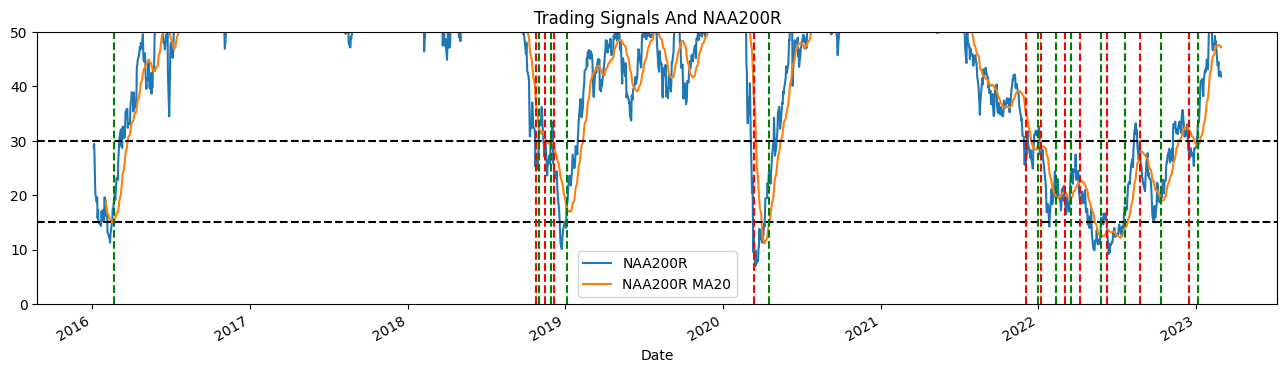

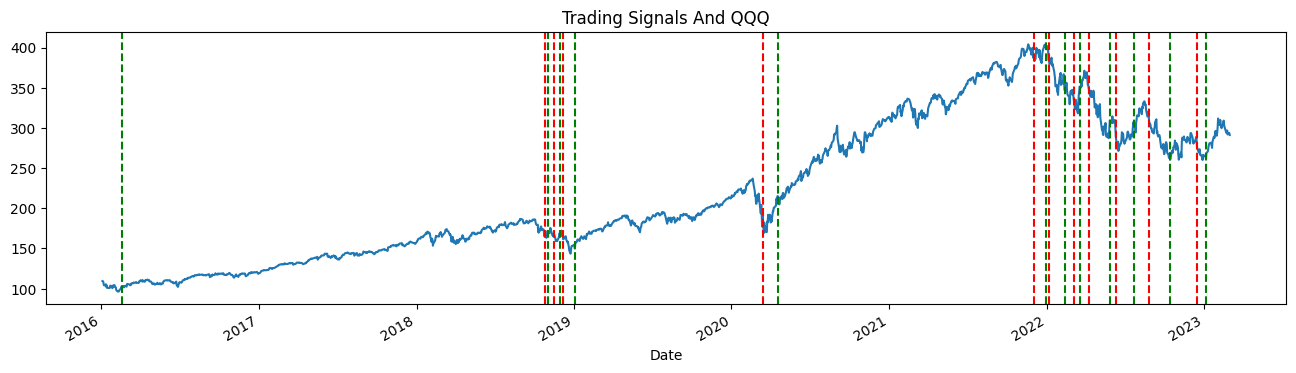

<Figure size 1600x400 with 0 Axes>

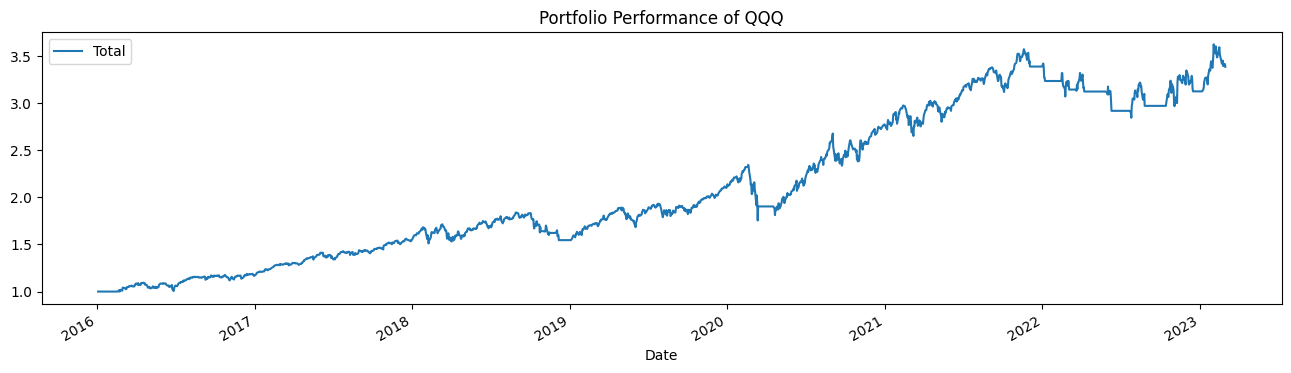

In [45]:
signal_ma_window = 20
buy_threshold = 15
sell_threshold = 30
ticker = qqq

naa200r_performance(qqq, test_start, test_end, signal_ma_window, buy_threshold , sell_threshold,  weekly_trading = True, visualization=True)


TH 15/30 MA 20: 
cumulative return      : 241.58%
compound anual return  : 9.2209% 
max_drawdown           : -23.33%
sharp_ratio            : 6.54%
average of daily return: 0.0748%
std of daily return    : 1.1442%
number of trades       : 18,
trading days           : 2616,
Betting Average        : 41.18%
Gain Average           : 29.57%
Loss Average           : -3.63%
Risk Reward Ratio      : 8.14
Gain STD               : 36.75%
Loss STD               : 1.87%
        
None


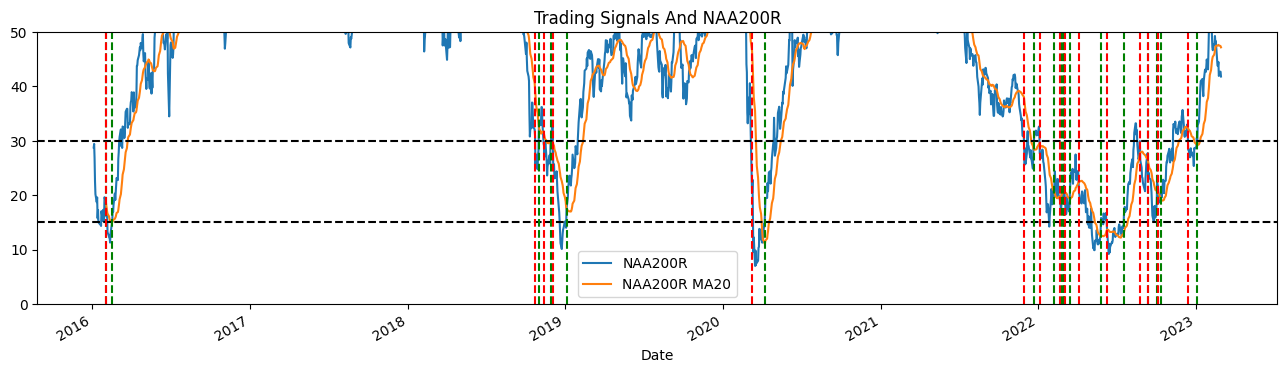

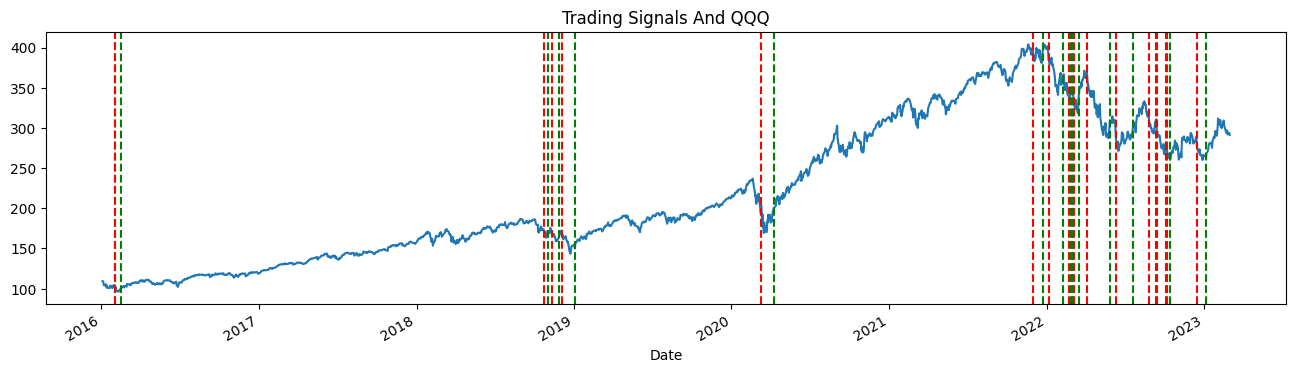

<Figure size 1600x400 with 0 Axes>

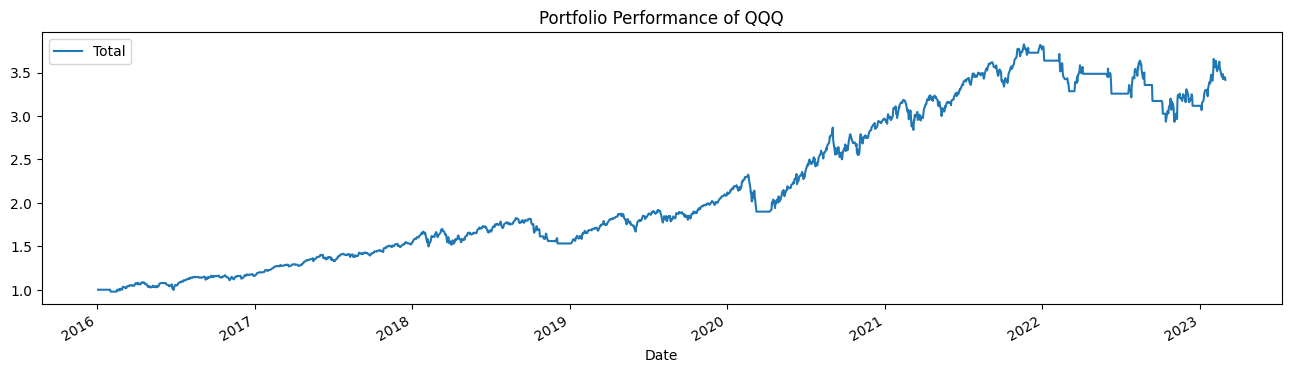

In [46]:
naa200r_performance(qqq, test_start, test_end, signal_ma_window, buy_threshold , sell_threshold,  weekly_trading = False, visualization=True)